# Analisi di Clustering sul Dataset di Transazioni con Frodi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import json

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


In [15]:
# Caricamento dei dati
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
  with zip_ref.open('transactions_data.csv') as f:
        transaction = pd.read_csv(f)
  with zip_ref.open('users_data.csv') as f:
        users = pd.read_csv(f)
  with zip_ref.open('cards_data.csv') as f:
        cards = pd.read_csv(f)
  with zip_ref.open('train_fraud_labels.json') as f:
        transaction_fraud = pd.read_json(f)
  with zip_ref.open('mcc_codes.json') as f:
        mcc_codes = json.load(f) 
trans_final = pd.read_pickle('./trans_final.pkl')
trans_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 36 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id_trans               int64         
 1   client_id_trans        int64         
 2   card_id                int64         
 3   amount                 float32       
 4   use_chip               object        
 5   merchant_id            int64         
 6   merchant_city          object        
 7   merchant_state         object        
 8   day                    object        
 9   time                   object        
 10  fraud                  float64       
 11  client_id_card         int64         
 12  card_brand             object        
 13  card_type              object        
 14  expires                datetime64[ns]
 15  has_chip               object        
 16  num_cards_issued       int64         
 17  credit_limit           float32       
 18  acct_open_date      

In [16]:
#eliminazione righe in cui non si ha info sulla frode
trans_final.dropna(subset=['fraud'], inplace=True)
#trasformazione delle colonne categoriche in numeriche
le = LabelEncoder()
for column in ['mcc_description', 'merchant_city', 'merchant_state','use_chip','card_brand','card_type','gender','has_chip']:
    trans_final[column] = le.fit_transform(trans_final[column])

to_drop = ['id_trans','client_id_trans','card_id','client_id_card','id','retirement_age','address','expires','day','time']
trans_final = trans_final.drop(to_drop, axis=1)

trans_final = trans_final.apply(pd.to_numeric, downcast='integer') 
trans_final = trans_final.apply(pd.to_numeric, downcast='float') 



In [17]:
trans_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8914963 entries, 0 to 13305912
Data columns (total 26 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   amount                 float32
 1   use_chip               int8   
 2   merchant_id            float32
 3   merchant_city          int16  
 4   merchant_state         int16  
 5   fraud                  int8   
 6   card_brand             int8   
 7   card_type              int8   
 8   has_chip               int8   
 9   num_cards_issued       int8   
 10  credit_limit           float32
 11  acct_open_date         float64
 12  year_pin_last_changed  int16  
 13  card_valid_month       int16  
 14  current_age            int8   
 15  birth_year             int16  
 16  gender                 int8   
 17  latitude               float32
 18  longitude              float32
 19  per_capita_income      float32
 20  yearly_income          float32
 21  total_debt             float32
 22  credit_score          

In [18]:


# Scalatura
scaler = StandardScaler()
X_scaled = scaler.fit_transform(trans_final)

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

trans_final_clustered = trans_final.loc[trans_final.index].copy()
trans_final_clustered['cluster'] = cluster_labels

# Tasso di frodi per cluster
fraud_rate = trans_final_clustered.groupby('cluster')['fraud'].mean()
print(fraud_rate)


cluster
0    0.001801
1    0.001913
2    0.001456
3    0.001096
4    0.001104
Name: fraud, dtype: float64


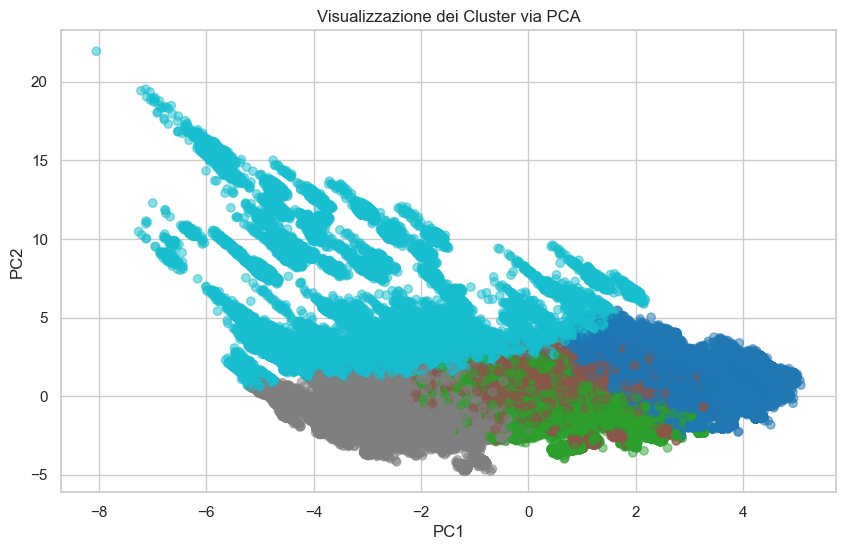

In [19]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=trans_final_clustered['cluster'], cmap='tab10', alpha=0.5)
plt.title('Visualizzazione dei Cluster via PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [20]:
fraud_rate = trans_final_clustered.groupby('cluster')['fraud'].mean()
transaction_count = trans_final_clustered['cluster'].value_counts().sort_index()

cluster_stats = pd.DataFrame({
    'Fraud Rate': fraud_rate,
    'Num Transactions': transaction_count
})

print(cluster_stats.sort_values('Fraud Rate', ascending=False))

         Fraud Rate  Num Transactions
cluster                              
1          0.001913           2035889
0          0.001801           1651255
2          0.001456           2026857
4          0.001104            549854
3          0.001096           2651108


In [21]:
cluster_id = cluster_stats['Fraud Rate'].idxmax()  # quello con più frodi

cluster_fraud = trans_final_clustered[trans_final_clustered['cluster'] == cluster_id]

print(cluster_fraud.describe())

             amount      use_chip   merchant_id  merchant_city  \
count  2.035889e+06  2.035889e+06  2.035889e+06   2.035889e+06   
mean   3.796049e+01  1.053463e+00  4.766121e+04   6.044165e+03   
std    6.924186e+01  9.347643e-01  2.576868e+04   3.267148e+03   
min   -5.000000e+02  0.000000e+00  2.000000e+00   0.000000e+00   
25%    8.260000e+00  0.000000e+00  2.571700e+04   3.359000e+03   
50%    2.604000e+01  1.000000e+00  4.628400e+04   6.643000e+03   
75%    5.783000e+01  2.000000e+00  6.765400e+04   8.210000e+03   
max    2.573480e+03  2.000000e+00  1.003400e+05   1.217100e+04   

       merchant_state         fraud    card_brand     card_type      has_chip  \
count    2.035889e+06  2.035889e+06  2.035889e+06  2.035889e+06  2.035889e+06   
mean     9.765893e+01  1.912678e-03  2.272464e+00  8.734808e-01  9.279067e-01   
std      5.233944e+01  4.369234e-02  7.274846e-01  5.905433e-01  2.586424e-01   
min      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   


In [22]:
cluster_normal = cluster_stats['Fraud Rate'].idxmin()
trans_final_clustered[trans_final_clustered['cluster'] == cluster_normal].describe()

,amount,use_chip,merchant_id,merchant_city,merchant_state,fraud,card_brand,card_type,has_chip,num_cards_issued,...,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,years_to_retire,mcc_description,cluster
count,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,...,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2.651108e+06,2651108.0
mean,4.228572e+01,1.160881e+00,4.742629e+04,5.943977e+03,1.056310e+02,1.095768e-03,2.233573e+00,7.273242e-01,8.899430e-01,1.480722e+00,...,3.776673e+01,-9.036806e+01,2.254495e+04,4.597126e+04,6.445296e+04,7.238114e+02,3.277307e+00,2.857283e+01,5.767437e+01,3.0
std,7.695567e+01,9.309733e-01,2.580293e+04,3.341237e+03,5.267616e+01,3.308426e-02,7.402905e-01,5.507476e-01,3.129609e-01,5.106064e-01,...,4.717223e+00,1.470889e+01,6.799359e+03,1.385067e+04,4.053445e+04,6.005104e+01,1.279408e+00,6.751061e+00,2.865498e+01,0.0
min,-5.000000e+02,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,2.134000e+01,-1.581800e+02,0.000000e+00,2.365000e+03,0.000000e+00,4.890000e+02,1.000000e+00,1.100000e+01,0.000000e+00,3.0
25%,8.650000e+00,0.000000e+00,2.580500e+04,2.935000e+03,6.800000e+01,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,3.400000e+01,-9.667000e+01,1.767900e+04,3.604500e+04,3.619900e+04,6.900000e+02,2.000000e+00,2.400000e+01,3.400000e+01,3.0
50%,2.990000e+01,2.000000e+00,4.479500e+04,6.356000e+03,1.200000e+02,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.881000e+01,-8.683000e+01,2.137300e+04,4.357900e+04,5.982700e+04,7.240000e+02,3.000000e+00,2.800000e+01,5.900000e+01,3.0
75%,6.427000e+01,2.000000e+00,6.619250e+04,8.036000e+03,1.320000e+02,0.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,...,4.124000e+01,-7.983000e+01,2.643100e+04,5.389000e+04,9.325500e+04,7.670000e+02,4.000000e+00,3.300000e+01,8.700000e+01,3.0
max,3.303680e+03,2.000000e+00,1.003400e+05,1.217100e+04,1.990000e+02,1.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,3.000000e+00,...,4.853000e+01,-6.983000e+01,4.769800e+04,9.724800e+04,2.521060e+05,8.500000e+02,9.000000e+00,4.800000e+01,1.070000e+02,3.0


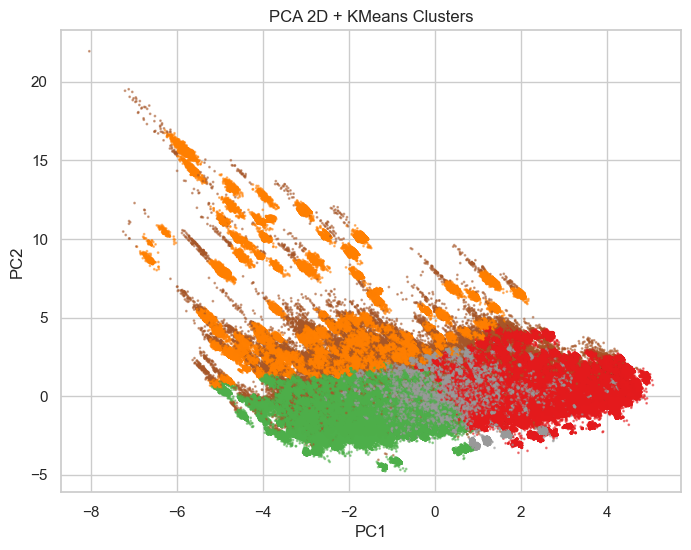

In [24]:
#cluster multidimensionali: PCA + Kmeans
# Seleziona tutte le features tranne 'fraud'
features = trans_final.drop(columns=['fraud'])

# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# PCA per visualizzazione (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Visualizza
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set1', s=1, alpha=0.5)
plt.title('PCA 2D + KMeans Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:

#non funziona ancora perchè è troppo grande il dataset
# DBSCAN su campione ridotto + PCA10
db = DBSCAN(eps=3, min_samples=50).fit(X_pca[:100000])

#cluster multidimensionale con dbscan
db = DBSCAN(eps=2, min_samples=50).fit(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db.labels_, cmap='viridis', s=1)
plt.title('PCA 2D + DBSCAN Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

MemoryError: 

In [ ]:
#mi fa schifo forse meglio cambiare colonne comunque concettualmente è uguale
#cluster bidimensionale con kmeans
# Seleziona solo le colonne necessarie e rimuove i valori mancanti
df_kmeans = trans_final[['credit_limit', 'amount']].dropna()

# Applica KMeans (es. con 4 cluster)
kmeans = KMeans(n_clusters=4, init='random', max_iter=300, n_init=10, random_state=0)
y_means = kmeans.fit_predict(df_kmeans)

# Plot dei cluster con colori e etichette personalizzate
plt.figure(figsize=(15,8))
plt.scatter(df_kmeans.values[y_means == 0, 0], df_kmeans.values[y_means == 0, 1], 
            s=100, c='yellow', label='Basso limite, bassa spesa')
plt.scatter(df_kmeans.values[y_means == 1, 0], df_kmeans.values[y_means == 1, 1], 
            s=100, c='magenta', label='Basso limite, alta spesa')
plt.scatter(df_kmeans.values[y_means == 2, 0], df_kmeans.values[y_means == 2, 1], 
            s=100, c='cyan', label='Alto limite, alta spesa')
plt.scatter(df_kmeans.values[y_means == 3, 0], df_kmeans.values[y_means == 3, 1], 
            s=100, c='pink', label='Alto limite, bassa spesa')

# Centroidi
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            s=200, c='blue', label='Centroidi')

# Titoli e legenda
plt.title('KMeans Clustering: Limite di Credito vs Spesa', fontsize=20)
plt.xlabel('Limite di credito (credit_limit)')
plt.ylabel('Importo speso (amount)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'hhh' is not defined

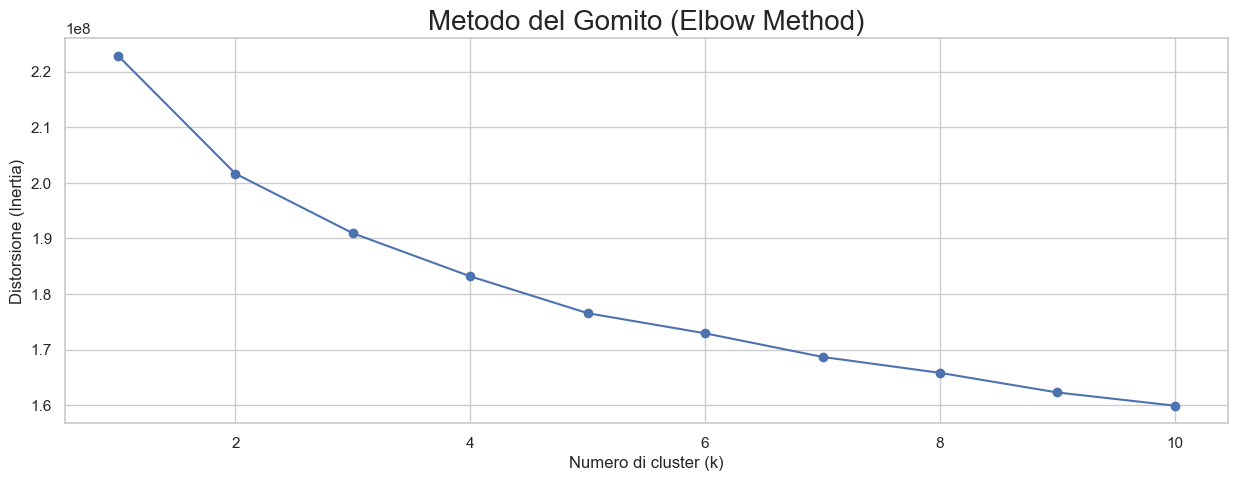

In [ ]:
# Step 2: Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(trans_final)

# Step 3: Metodo del gomito per trovare il k ottimale
distortions = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

# Step 4: Visualizzazione
plt.figure(figsize=(15, 5))
plt.plot(K, distortions, 'bo-')
plt.title('Metodo del Gomito (Elbow Method)', fontsize=20)
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Distorsione (Inertia)')
plt.grid(True)
plt.show()

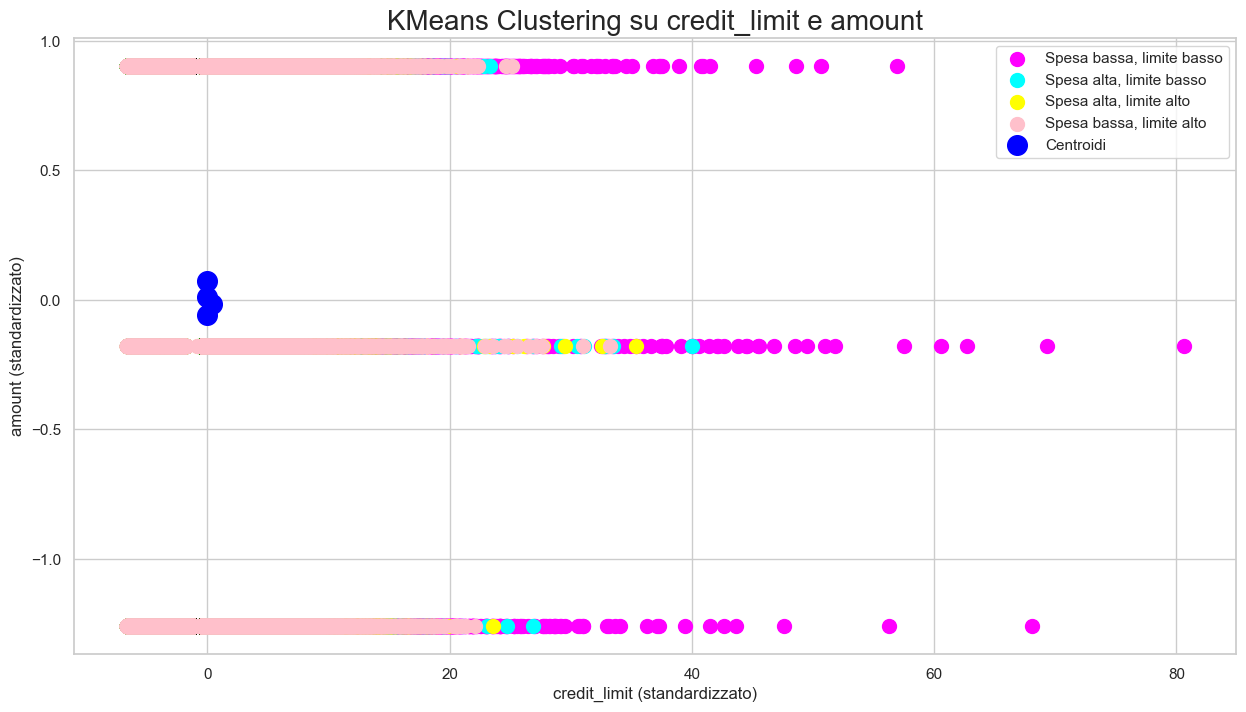

In [ ]:
# Supponiamo che k = 4
k = 4

# Clustering finale
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# Visualizzazione dei cluster
plt.figure(figsize=(15, 8))
colors = ['magenta', 'cyan', 'yellow', 'pink']
labels = ['Spesa bassa, limite basso', 'Spesa alta, limite basso', 'Spesa alta, limite alto', 'Spesa bassa, limite alto']

for i in range(k):
    plt.scatter(X_scaled[y_kmeans == i, 0], X_scaled[y_kmeans == i, 1], 
                s=100, c=colors[i], label=labels[i])

# Centroidi
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c='blue', label='Centroidi')

plt.title('KMeans Clustering su credit_limit e amount', fontsize=20)
plt.xlabel('credit_limit (standardizzato)')
plt.ylabel('amount (standardizzato)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#questo e quelli sotto non ho ancora visto se funzionano
# Metodo della silhouette
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot silhouette score
plt.plot(K, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Numero di Cluster')
plt.xlabel('Numero di Cluster')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
# Calcolo linkage
Z = linkage(X_scaled, method='ward')

# Dendrogramma
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='lastp', p=20, leaf_rotation=45., leaf_font_size=10.)
plt.title('Dendrogramma - Hierarchical Clustering')
plt.xlabel('Cluster')
plt.ylabel('Distanza')
plt.show()

In [ ]:
agg = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = agg.fit_predict(X_scaled)

# Visualizzazione
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, palette='tab10', s=10)
plt.title('Hierarchical Clustering - Scatter Plot')
plt.xlabel('amount (scaled)')
plt.ylabel('credit_limit (scaled)')
plt.legend(title='Cluster')
plt.show()